<a href="https://colab.research.google.com/github/iashyam/Pytorch-Tutorial/blob/main/RNNs_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import torch
from torch.utils.data import Dataset, DataLoader
import string
import unicodedata
import torch.nn.functional as F
from torch import nn
import os
from tqdm import tqdm

In [21]:
import requests
import zipfile
def download_data(link):
    with open('download', 'wb') as f:
        f.write(requests.get(link).content)

    with zipfile.ZipFile('download', 'r') as zip_ref:
        zip_ref.extractall('.')

download_data('https://download.pytorch.org/tutorial/data.zip')

In [22]:
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

def wordToUnicode(word: str) -> str:

    '''remove things likea accents so we can process thigs better'''

    return ''.join(
        c for c in unicodedata.normalize('NFD', word)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [23]:
def wordToTensor(word: str) -> torch.Tensor:

    ret = torch.zeros((len(word), 1, n_letters))

    for li, letter in enumerate(word):
        one_hot = torch.zeros(n_letters)
        index = -1
        if letter in allowed_characters:
            index = allowed_characters.find(letter)
        one_hot[index] = 1
        ret[li] = one_hot
    return ret


In [24]:
data_dir = 'data/names'


def parse_files(data_dir: str) -> tuple[list, dict]:

    lables = []
    lables_to_names = {}

    for file in os.listdir(data_dir):
        if file.endswith('.txt'):
            label = os.path.splitext(file)[0]
            file = os.path.join(data_dir, file)
            lables_to_names[label] = []
            lables.append(label)
            with open(file, 'r') as f:
                for lines in f:
                    lables_to_names[label].append(wordToUnicode(lines.strip()))

    return lables, lables_to_names

In [47]:
class wordsDataset(Dataset):

    def __init__(self, data_dir):
        self.labels, self.labels_to_names = parse_files(data_dir)
        self.all_names = [(name, label) for label, names in self.labels_to_names.items() for name in names]

    def __len__(self):
        return len(self.all_names)

    def get_labels(self):
        return self.labels

    def __getitem__(self, idx):
        name, label = self.all_names[idx]
        name_tensor = wordToTensor(name)
        label_tensor = torch.tensor(self.labels.index(label), dtype=torch.long)
        return name_tensor, label_tensor

In [26]:
class simpleRNN(nn.Module):

    def __init__(self, input_size: int, hidden: int, output: int) -> None:
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden)
        self.fc = nn.Linear(hidden, output)

    def forward(self, x):
        output, hidden = self.rnn(x)
        x = self.fc(hidden[0])
        return x

In [27]:
model = simpleRNN(n_letters, 128, 18)

In [28]:
print(model)

simpleRNN(
  (rnn): RNN(58, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
)


In [29]:
model(wordToTensor('hello'))

tensor([[-0.1080,  0.0806, -0.1772,  0.0166,  0.0380, -0.0113,  0.0773,  0.1006,
         -0.1435,  0.1165,  0.0483,  0.0514,  0.0845,  0.0037, -0.0689,  0.0714,
          0.0141, -0.0226]], grad_fn=<AddmmBackward0>)

In [30]:
def train_stepper(model, optimizer, loss_fn, device):

    def step(x, y):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    return step

In [31]:
import random
import numpy as np
def train_loop(model, optimizer, loss_fn, device, data, epochs: int, batch_size: int) -> dict:

    model.to(device)
    model.train()

    history = {}
    history['train_loss'] = []

    ## trying to a batch training setup
    indices = list(range(len(data)))
    random.shuffle(indices)

    num_batches  = len(data) // batch_size
    batch_indices = np.array_split(indices, num_batches)

    for epoch in range(epochs):
        epoch_loss = 0
        avg_epoch_loss = 0
        for i, batch in (bar := tqdm(enumerate(batch_indices))):
            bar.set_description(f'epoch: {epoch}')
            batch_loss = 0
            for index in batch:
                x, y = data[index]

                x = x.to(device)
                y = y.to(device).unsqueeze(0)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                batch_loss += loss

            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += batch_loss.item()
            avg_epoch_loss = epoch_loss / ((i+1)*batch_size)
            bar.set_postfix({'loss': round(avg_epoch_loss, 4), 'batch':f'{i} of {num_batches}'})

        history['train_loss'].append(avg_epoch_loss)

    return history


In [32]:
np.array_split(list(range(40)), 3)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])]

In [33]:
optmizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')

using device: cuda


In [34]:
data = wordsDataset(data_dir)
epochs = 27
dataloader = DataLoader(data, batch_size=128, shuffle=True)
hisotry = train_loop(model, optmizer, loss_fn, device, data, batch_size=64, epochs=epochs)

epoch: 0: : 313it [00:23, 13.27it/s, loss=1.48, batch=312 of 313]
epoch: 1: : 313it [00:23, 13.31it/s, loss=1.06, batch=312 of 313]
epoch: 2: : 313it [00:23, 13.35it/s, loss=0.91, batch=312 of 313]
epoch: 3: : 313it [00:23, 13.36it/s, loss=0.83, batch=312 of 313]
epoch: 4: : 313it [00:23, 13.34it/s, loss=0.778, batch=312 of 313]
epoch: 5: : 313it [00:23, 13.37it/s, loss=0.736, batch=312 of 313]
epoch: 6: : 313it [00:23, 13.34it/s, loss=0.701, batch=312 of 313]
epoch: 7: : 313it [00:23, 13.16it/s, loss=0.67, batch=312 of 313]
epoch: 8: : 313it [00:24, 12.96it/s, loss=0.643, batch=312 of 313]
epoch: 9: : 313it [00:24, 12.93it/s, loss=0.618, batch=312 of 313]
epoch: 10: : 313it [00:24, 12.61it/s, loss=0.594, batch=312 of 313]
epoch: 11: : 313it [00:24, 12.80it/s, loss=0.573, batch=312 of 313]
epoch: 12: : 313it [00:24, 12.75it/s, loss=0.552, batch=312 of 313]
epoch: 13: : 313it [00:24, 12.76it/s, loss=0.533, batch=312 of 313]
epoch: 14: : 313it [00:24, 12.95it/s, loss=0.515, batch=312 of 

In [35]:
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    plt.plot(history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

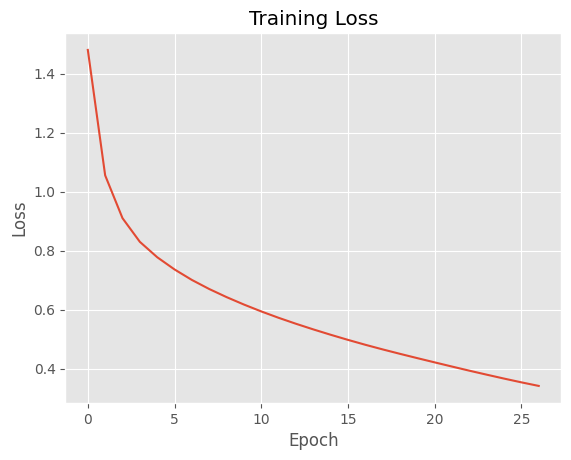

In [36]:
plot_history(hisotry)

In [48]:
def output_to_label(output, labels):
    softmax = F.softmax(output, dim=1)
    return labels[torch.argmax(softmax, dim=1)]

In [63]:
def guess_nationality(word):
    model.eval()
    output = model(wordToTensor(word).to(device))
    data = wordsDataset(data_dir)
    labels = data.get_labels()
    return output_to_label(output, labels)

In [64]:
guess_nationality('kang')

'Korean'

In [66]:
torch.save(model.state_dict(), 'nationality_model.pth')